# SMS Spam Analysis

# Imports

In [34]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

# Models 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.gaussian_process import GaussianProcessClassifier
from xgboost import XGBClassifier

# Data Processing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from imblearn.over_sampling import SMOTE


from collections import Counter

import torch
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.tokenize import word_tokenize

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Functions

In [60]:
def check_class_imbalance(df:pd.DataFrame, target:pd.Series, col:str):
  counter = Counter(target)
  for k,v in counter.items():
    per = v/len(target) * 100
    print("Class=%s, Count=%d, Percentage=%.3f%%" % (k,v, per))
  
  ax = df[col].value_counts().sort_index().plot(
  kind="bar", 
  title="Count of Reviews by Target", 
  figsize=(10,5)
  )
  ax.set_xlabel(col)
  plt.show()
  
def remove_stop_words(review:str):
    word_tokens = " ".join(word_tokenize(review))
    filtered_word_tokens = re.sub(r'[^a-zA-Z\s]', '', word_tokens).split(" ")
    filtered_sentence = [w.lower().strip() for w in filtered_word_tokens if not w.lower() in ENGLISH_STOP_WORDS]
    return ' '.join(filtered_sentence).strip()
def evaluate_model(X, y, model):
  cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
  
  metric = make_scorer(f1_score)
  scores = cross_val_score(model, X, y, scoring=metric, cv=cv, n_jobs=-1)
  return scores

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        # Evaluate the model
        scores = evaluate_model(X, y, model)
        # summarize and store
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)
def get_selected_models(names):
  """
  Returns selected models for ML processing

  Args:
      names (_type_):List

  Returns:
      List of models
  """
  models = {
    "LDA": LinearDiscriminantAnalysis(),
    "GPC": GaussianProcessClassifier(),
    "GNB": GaussianNB(),
    "SVC": SVC(),
    "LR":LogisticRegression(max_iter=1000),
    "KNN": KNeighborsClassifier(),
    "DTC": DecisionTreeClassifier(),
    "GBC":GradientBoostingClassifier(),
    "RFC":RandomForestClassifier(),
    "XGB": XGBClassifier(),
    "MN": MultinomialNB()
  }
  
  return [models[model] for model in names]

def testing_selected_models(names:list, models:list, X:pd.DataFrame, y:pd.Series):
    """
    Runs multiple subsets on folds of data

    Args:
        names (list): _description_
        models (list): _description_
    """
    model_performance = []
    for i in range(len(models)):
        model = models[i]
        scores = evaluate_model(X, y, model)
        model_performance.append({
            "Model": names[i],
            "Mean": np.mean(scores),
            "STD":np.std(scores)
        })
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Mean", ascending=False)

def test_train_test_val_splits_on_models(names, models, X, y):
    model_performance = []
    
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42)
    
    for i in range(len(models)):
        model, model_name = models[i], names[i]
        model.fit(X_train, y_train)
        
        y_val_pred = model.predict(X_val)
        val_accuracy = accuracy_score(y_val, y_val_pred)
        
        y_test_pred = model.predict(X_test)
        test_accuracy = accuracy_score(y_test, y_test_pred)
        
        model_performance.append({
            "Model": model_name,
            "Validation Accuracy": val_accuracy,
            "Test Accuracy": test_accuracy
        })
        
        conf_mat = confusion_matrix(y_test,y_test_pred)
        plt.figure(figsize=(8,6))
        sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted Labels')
        plt.ylabel('True Labels')
        plt.title(f'Confusion Matrix {model_name}')
        plt.show()
        
    performance_df = pd.DataFrame(model_performance)
    return performance_df.sort_values(by="Validation Accuracy", ascending=False)

#  EDA Analysis

In [6]:
df = pd.read_csv("/Users/maukanmir/Downloads/spam_sms.csv")
df

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [7]:
df.columns = ["target", "text"]

In [8]:
df

,target,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will Ì_ b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


# Check for Nulls and Dupes

In [9]:
print(f"Null Count: {df.isna().sum()}")
print(f"Dupe Count: {df.duplicated().sum()}")

Null Count: target    0
text      0
dtype: int64
Dupe Count: 403


# There are 403 cases of duplicates, however they all could be spam, we have to do more EDA before dropping these values. These duplicates could be relevant information

In [10]:
df[df.duplicated()]["target"].value_counts()

ham     309
spam     94
Name: target, dtype: int64

In [11]:
df[df.duplicated()]["text"].value_counts()

Sorry, I'll call later                                                                                                                                                                                                                                                                                                                       29
I cant pick the phone right now. Pls send a message                                                                                                                                                                                                                                                                                          11
Ok...                                                                                                                                                                                                                                                                                                                                   

# Interesting here, of the 403 dupes 309 are labeled as real emails while 94 as spam. Lets check if the same message is being labeled as both spam and ham in our dataset

In [12]:
dupe_df = df[df.duplicated()]

In [13]:
spam_df = dupe_df[dupe_df['target'] == 'spam']
ham_df = dupe_df[dupe_df['target'] == 'ham']

In [14]:

ham_series_text = ham_df["text"]
spam_series_text = spam_df['text']

dupe_texts = [text for text in ham_series_text if text in spam_series_text]
dupe_texts

[]

# The same message is not in spam and ham which is a good sign of data quality other than the dupes

In [15]:
df.drop_duplicates(inplace=True)

# Check Overall Class Imbalance

Class=ham, Count=4516, Percentage=87.367%
Class=spam, Count=653, Percentage=12.633%


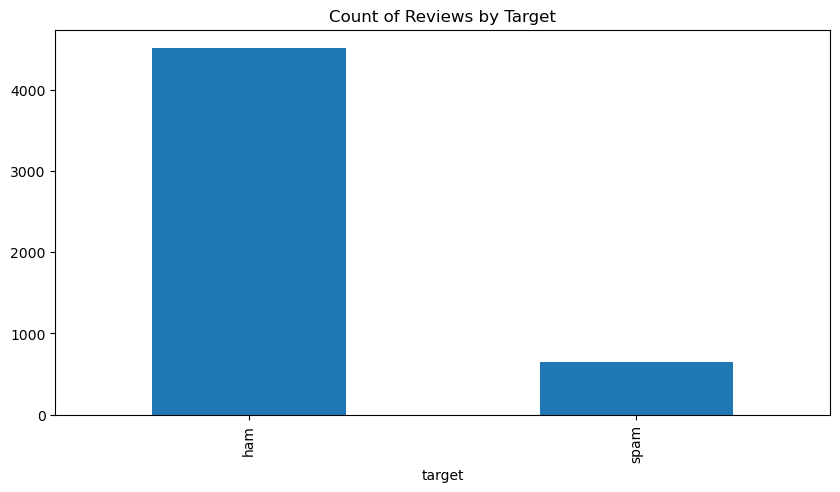

In [16]:
check_class_imbalance(df, df['target'], 'target')

# Heavily Imbalanced dataset, this means we have to implement over sampling techniques to help balance the dataset

In [17]:
df['len_of_text'] = df['text'].apply(lambda x: len(x))
df

,target,text,len_of_text
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,161
5568,ham,Will Ì_ b going to esplanade fr home?,37
5569,ham,"Pity, * was in mood for that. So...any other s...",57
5570,ham,The guy did some bitching but I acted like i'd...,125


In [18]:
df['num_words'] = df['text'].apply(lambda x: len(x.split()))

<AxesSubplot:xlabel='target', ylabel='len_of_text'>

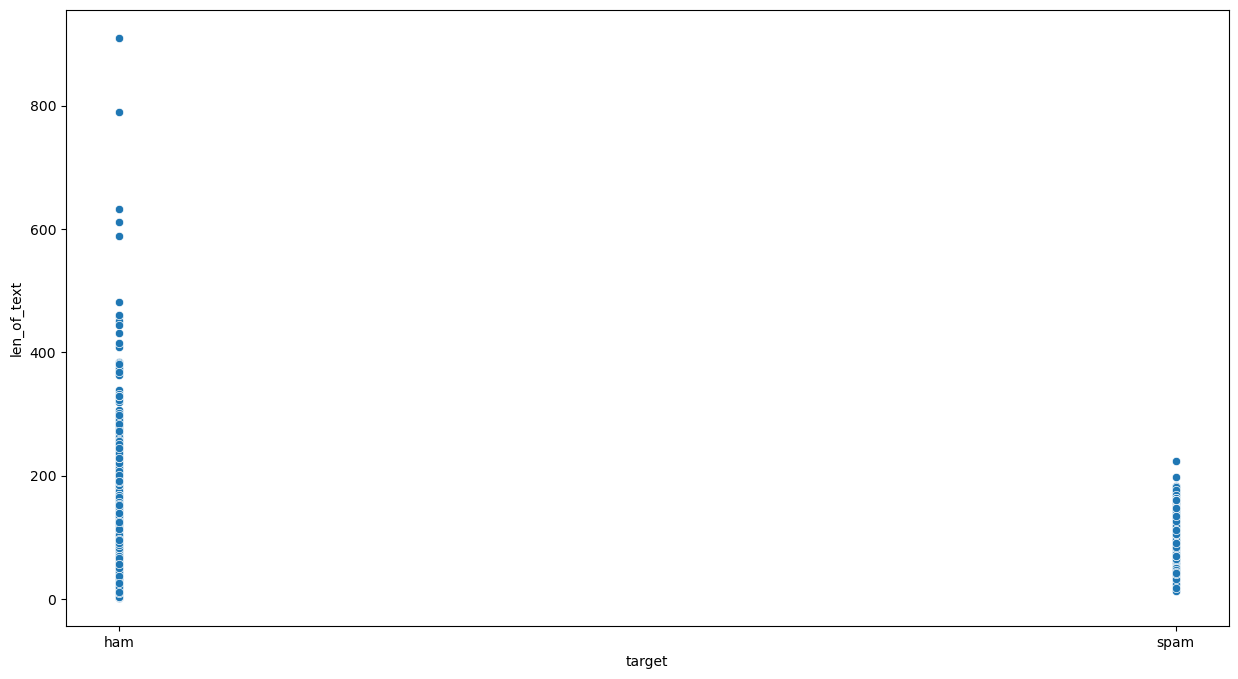

In [19]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x='target', y='len_of_text')

<AxesSubplot:xlabel='target', ylabel='num_words'>

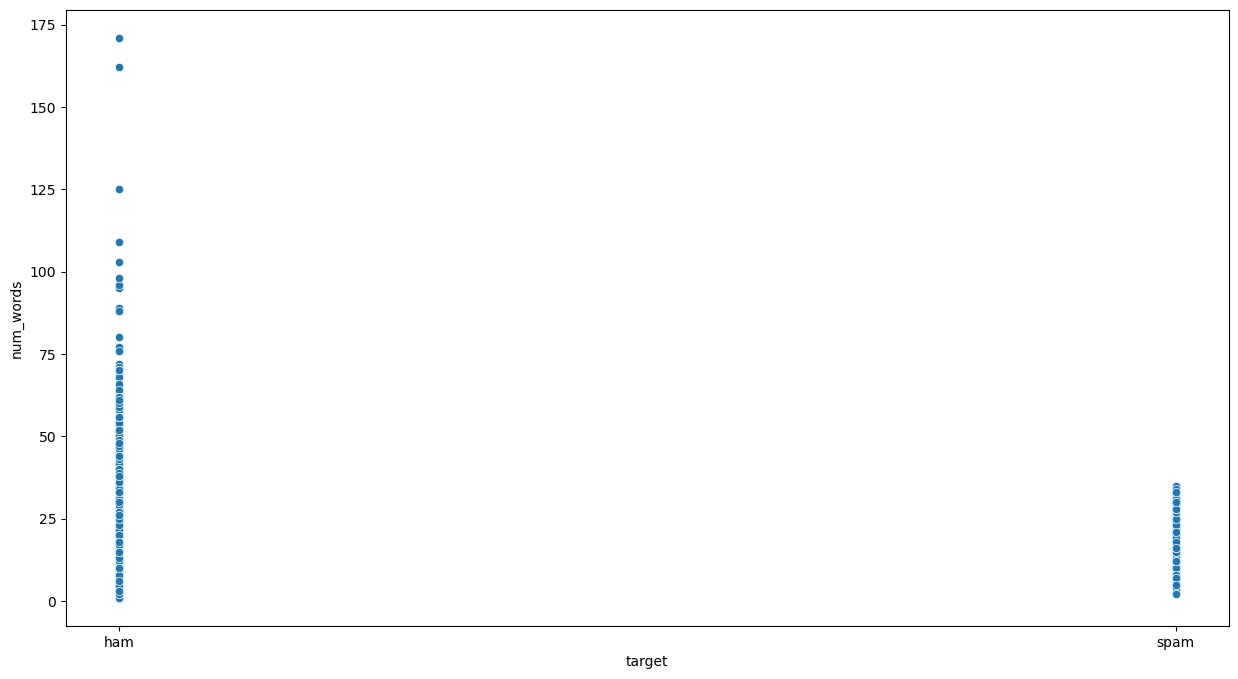

In [20]:
plt.figure(figsize=(15, 8))
sns.scatterplot(data=df, x='target', y='num_words')

# Spam messages seem to be have less length of text and number of words

# Data Pipeline

In [21]:
df['target'] = df['target'].apply(lambda x: 0 if x == "ham" else 1)

In [22]:
from transformers import DistilBertTokenizer, DistilBertModel

tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')
model = DistilBertModel.from_pretrained('distilbert-base-cased')


In [28]:
def get_embeddings(text:str):
    """
    - The function get_embeddings is designed to convert input text into a vector representation, 
    or embedding, using a transformer model 
    (like BERT or DistilBERT). These embeddings can be used for various 
    natural language processing tasks such as text classification, clustering, or similarity searches.
    
    - torch.no_grad(): This context manager tells PyTorch not to compute or store gradients. 
    This is important during inference when you only need to do forward propagation, 
    as it reduces memory consumption and speeds up computation.
    
    - last_hidden_state: This tensor contains the output features from the last layer of the 
    transformer for each token. 
    For models like BERT, this typically has dimensions 
    [batch_size, sequence_length, hidden_size]
    
    - This line calculates the mean of the last_hidden_state across the sequence length (tokens). 
    The mean operation reduces the tensor from [batch_size, sequence_length, hidden_size] 
    to [batch_size, hidden_size], resulting in a single vector representation for each 
    sequence in the batch. This vector captures the overall semantic meaning of the text.

    Args:
        text (str): _description_

    Returns:
        _type_: _description_
    """
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    
    with torch.no_grad():
        outputs = model(**inputs)
    
    last_hidden_states = outputs.last_hidden_state
    
    mean_embeddings = last_hidden_states.mean(dim=1)
    return mean_embeddings.numpy()

In [25]:

df['text_embeddings'] = df['text'].apply(lambda x: get_embeddings(x))

features = np.array(df['text_embeddings'].tolist()).reshape(df.shape[0], -1)

# Separate Features

In [26]:
y = df['target']

# Baseline Model

In [27]:
from sklearn.dummy import DummyClassifier

model = DummyClassifier(strategy='constant', constant=1) 

scores = evaluate_model(features, y, model)
print('Mean: %.3f (%.3f)' % (np.mean(scores), np.std(scores)))

Mean: 0.224 (0.001)


# Sampling Technique

In [35]:
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(features, y)

# Advanced Model Metrics

In [38]:
names = ['LR', "SVC"]
models = get_selected_models(names)
testing_selected_models(names, models, X_res, y_res)


/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,Model,Mean,STD
0,LR,0.995430,0.002204
1,SVC,0.991032,0.002991


# Test Tree Models

In [39]:
names = ['XGB', "GBC"]
models = get_selected_models(names)
testing_selected_models(names, models, X_res, y_res)

,Model,Mean,STD
0,XGB,0.996795,0.001879
1,GBC,0.993136,0.002898


In [41]:
names = ['RFC', "DTC"]
models = get_selected_models(names)
testing_selected_models(names, models, X_res, y_res)

,Model,Mean,STD
0,RFC,0.994896,0.001690
1,DTC,0.975245,0.003875


In [44]:
names = ['KNN', "LDA"]
models = get_selected_models(names)
testing_selected_models(names, models, X_res, y_res)

,Model,Mean,STD
1,LDA,0.993394,0.002034
0,KNN,0.971846,0.002270


# Train Test Val Splits Predictions

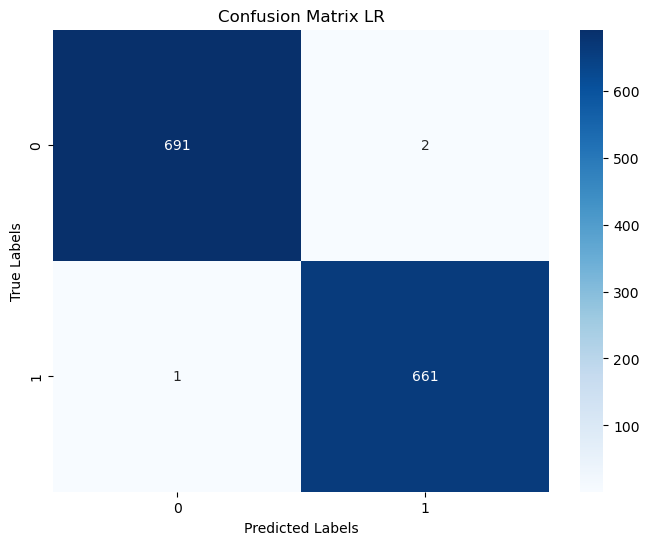

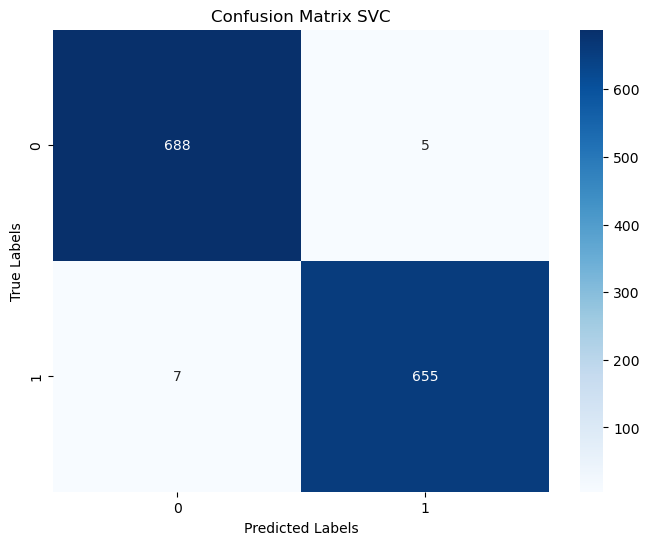

,Model,Validation Accuracy,Test Accuracy
0,LR,0.993358,0.997786
1,SVC,0.990406,0.991144


In [61]:
names = ['LR', "SVC"]
models = get_selected_models(names)
test_train_test_val_splits_on_models(names, models, X_res, y_res)

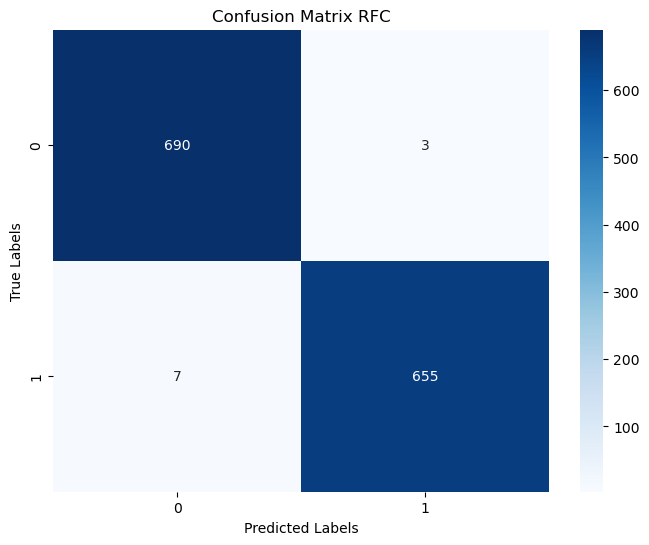

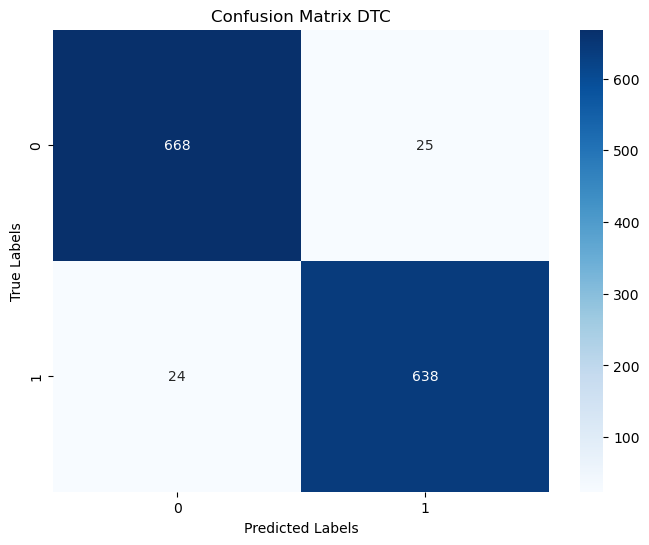

,Model,Validation Accuracy,Test Accuracy
0,RFC,0.994834,0.992620
1,DTC,0.964576,0.963838


In [63]:
names = ['RFC', "DTC"]
models = get_selected_models(names)
test_train_test_val_splits_on_models(names, models, X_res, y_res)

# MLP Tuning

In [45]:
from keras.optimizers import SGD, Adam, RMSprop
from keras.regularizers import l2, l1
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout

def create_keras_classifier(function, optimizer, idx, param, validation_data):
    if idx == 0:
        
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer)
            , epochs=100, 
            batch_size=64, 
            verbose=0,
            validation_data= validation_data
            )
    elif idx ==1:
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer, param=param)
            , epochs=100, 
            batch_size=64, 
            verbose=0,
            validation_data= validation_data
            )
        
    else:
        model = KerasClassifier(
            build_fn=lambda: function(input_dim=X_train.shape[1], optimizer=optimizer, param=param)
            , epochs=100, 
            batch_size=64, 
            verbose=0,
            validation_data= validation_data
            )
    return model

def create_model_dropout(input_dim, optimizer='adam'):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_regularizerl2(input_dim, optimizer="adam",param= 0.001):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu', kernel_regularizer=l2(param) ))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model
def create_model_regularizerL1(input_dim, optimizer="adam",param= 0.001):
    model = Sequential()
    model.add(Dense(64, input_dim=input_dim, activation='relu', activity_regularizer=l1(param) ))
    model.add(Dense(32, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model


X_train, X_temp, y_train, y_temp = train_test_split(X_res, y_res, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

functions = [
  create_model_dropout,
  create_model_regularizerL1,
  create_model_regularizerl2
]

optimizers = [
    Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07),
    RMSprop(learning_rate=0.001, rho=0.9, momentum=0.0, epsilon=1e-07),
    SGD(lr=0.01, momentum=0.9), 
    SGD(lr=0.001, momentum=0.9),
    ]
optimizer_names = ['Adam', "RmsProp", "SGD:0.01", "SGD:0.001"]
function_names = ["Dropout", "L1", "L2"]
values = [1e-1, 1e-2, 1e-3, 1e-4]
model_performance = []
for index, function in enumerate(functions):
    name = function_names[index]
    for idx, optimizer in enumerate(optimizers):
        optimizer_name = optimizer_names[idx]
        value = values[idx]
        model = create_keras_classifier(function, optimizer, index, value, (X_val, y_val))
        
        model.fit(X_train, y_train)
        accuracy = model.score(X_test, y_test)
        model_performance.append({
            "Model": name,
            "Accuracy": accuracy,
            "Optimizer": optimizer_name,
            "Value": value
        })
model_df = pd.DataFrame(model_performance)
end_result = model_df.sort_values(by="Accuracy", ascending=False)
end_result

/Users/maukanmir/miniforge3/envs/machine-learning-env/lib/python3.9/site-packages/keras/optimizers/optimizer_v2/gradient_descent.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_10110/130475220.py:10: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(
2024-05-02 17:47:55.399116: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
/var/folders/bb/2qsf8cm95jg05zrms2_8m2qr0000gn/T/ipykernel_10110/130475220.py:18: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  model = KerasClassifier(
/var/folders/bb/2qsf8cm95jg05

,Model,Accuracy,Optimizer,Value
2,Dropout,0.998580,SGD:0.01,0.0010
0,Dropout,0.997869,Adam,0.1000
1,Dropout,0.997869,RmsProp,0.0100
6,L1,0.997159,SGD:0.01,0.0010
10,L2,0.995739,SGD:0.01,0.0010
11,L2,0.995739,SGD:0.001,0.0001
3,Dropout,0.990186,SGD:0.001,0.0001
8,L2,0.990186,Adam,0.1000
7,L1,0.987345,SGD:0.001,0.0001
5,L1,0.986635,RmsProp,0.0100


# LSTM

In [48]:
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, Dense
from tensorflow.keras.models import Sequential

model = Sequential()

vocab_size = len(tokenizer.get_vocab()) + 1 
model.add(Embedding(input_dim=vocab_size, output_dim=32))
model.add(Bidirectional(LSTM(32, activation='tanh')))
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [49]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          927904    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense_36 (Dense)            (None, 128)               8320      
                                                                 
 dense_37 (Dense)            (None, 256)               33024     
                                                                 
 dense_38 (Dense)            (None, 128)               32896     
                                                                 
 dense_39 (Dense)            (None, 1)                 129       
                                                     

In [51]:
seq = [sequence for sequence in df['text']]
model_inputs = tokenizer(seq, padding=True, return_tensors='tf')

In [52]:
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((model_inputs['input_ids'], y))

In [53]:
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

# Add Train, Test and Val features

In [54]:
len_dataset= len(dataset)

train = dataset.take(int(len_dataset*.7))
test = dataset.skip(int(len_dataset*.7)).take(int(len_dataset*.2))
val = dataset.skip(int(len_dataset*.9)).take(int(len_dataset*.1))

In [55]:

history = model.fit(train, epochs=5, batch_size=16, verbose=0, validation_data=val)

# Learning Curves

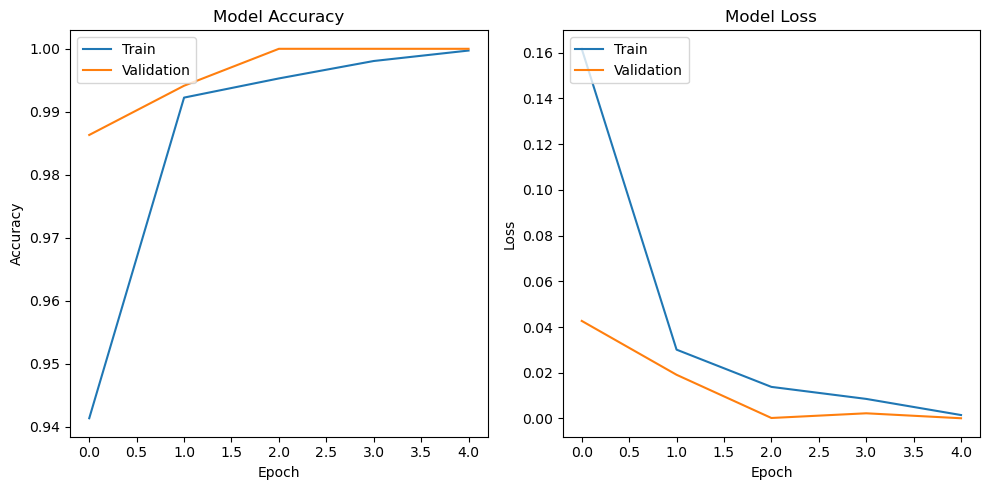

In [56]:
# Plot training & validation accuracy values
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()